In [1]:
import numpy as np
from mkidreadoutanalysis.mkidnoiseanalysis import plot_channel_fft, plot_psd, apply_lowpass_filter, compute_r
from mkidreadoutanalysis.resonator import *
from mkidreadoutanalysis.mkidreadout import MKIDReadout
from mkidreadoutanalysis.optimal_filters.make_filters import Calculator
import scipy as sp
from mkidreadoutanalysis.optimal_filters.filters import wiener

# Create 2MHz IQ of pulse (w/ noise) of photons at various arrival times
resonator = Resonator(f0=4.0012e9, qi=200000, qc=15000, xa=1e-9, a=0, tls_scale=1) #1e2
rf = RFElectronics(gain=(np.pi, 0, 0), phase_delay=np.pi, cable_delay=50e-9)
freq = FrequencyGrid( fc=4.0012e9, points=1000, span=500e6)

sweep = ResonatorSweep(resonator, freq, rf)
# plot sweep to make sure we are rotated and centered


#These are values for settings later on that you shouldn't exceed otherwise you'll be unlikely to have sufficient data
n_template_max = 750
min_noise_window_max = 2000 
pre_pulse_avoid_max = 10

n_template_max = 750
min_noise_window_max = 2000 
pre_pulse_avoid_max = 10
desired_pulses = 3000

typical_us_between_photon=(n_template_max+pre_pulse_avoid_max+min_noise_window_max)
advisable_max_count_rate = int(1/typical_us_between_photon*1e6)
needed_duration = desired_pulses/advisable_max_count_rate
iq_data_volume=np.complex128().itemsize*2e6*needed_duration/1024**2

print(f'For settings requested using a count rate of {advisable_max_count_rate}, '
      f'and a duration of {needed_duration:.1f} s. Data volume will be ~{iq_data_volume:.0f} MB.')
if iq_data_volume>1000:
    raise RuntimeError('Sure you want to generate more that 1Gig of IQ values?')

quasiparticle_timestream = QuasiparticleTimeStream(fs = 2e6, ts = needed_duration)
quasiparticle_timestream.gen_photon_arrivals(cps=advisable_max_count_rate);

For settings requested using a count rate of 362, and a duration of 8.3 s. Data volume will be ~253 MB.


In [2]:
# quasiparticle_timestream.populate_photons_random_phasing(magnitude=np.pi/2);
quasiparticle_timestream.populate_photons(magnitude=np.pi/2);

In [ ]:
#quasiparticle_timestream.plot_timeseries(quasiparticle_timestream.data)

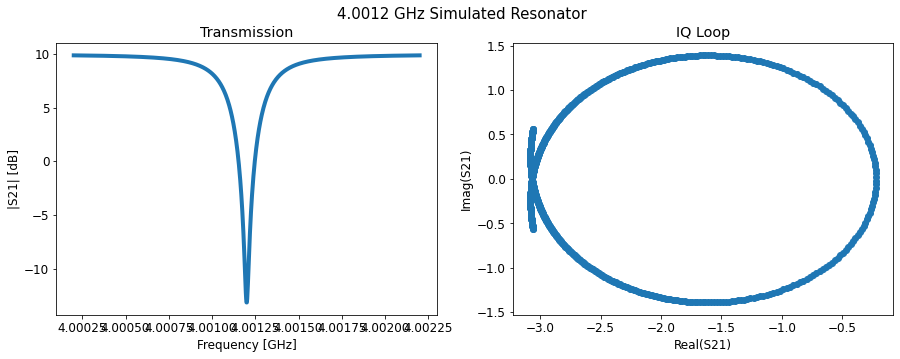

In [3]:
sweep.plot_sweep()

In [4]:
lowpass8coe = np.array([-0.08066211966627938, 0.02032901400427789, 0.21182262325068868, 0.38968583545138658, 0.38968583545138658, 0.21182262325068868, 0.02032901400427789, -0.08066211966627938])
lowpass20coe = np.array([6,0,-4,-3,5,6,-6,-13,7,44,64,44,7,-13,-6,6,5,-3,-4,0,6], dtype=float)
lowpass20coe/=np.trapz(lowpass20coe)
from scipy.signal import lfilter,lfiltic
lowpass8 = lambda data : lfilter(lowpass8coe, 1, data)[8:]
lowpass20 = lambda data : lfilter(lowpass20coe, 1, data)[20:]
def plot_lowpass(fs, filter_coe):
    from scipy import signal
    w, h = signal.freqz(b=filter_coe, a=1)
    x = w * fs * 1.0 / (2 * np.pi)
    y = 20 * np.log10(abs(h))
    plt.figure(figsize=(10, 5))
    plt.semilogx(x, y)
    plt.ylabel('Amplitude [dB]')
    plt.xlabel('Frequency [Hz]')
    plt.title('Frequency response')
    plt.grid(which='both', linestyle='-', color='grey')
    plt.show()

In [5]:
lit_res_measurment = ReadoutPhotonResonator(resonator, quasiparticle_timestream, freq, rf)

# toggle white noise and line noise
lit_res_measurment.noise_on = True
# adjust white noise scale
lit_res_measurment.rf.noise_scale = 30
# configure line noise
lit_res_measurment.rf.line_noise.freqs = ([60, 50e3, 100e3, 250e3, -300e3, 300e3, 500e3]) # Hz and relative to center of bin (MKID we are reading out)
lit_res_measurment.rf.line_noise.amplitudes = ([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.01])
lit_res_measurment.rf.line_noise.phases = ([0, 0.5, 0,1.3,0.5, 0.2, 2.4])

In [6]:
lowpass_to_use = lowpass8
lowpass_drop = 8

In [7]:
def pulse(amp, t, t0, tf=20):
    p = np.zeros_like(t)
    p[t >= t0] = amp*np.exp(-(t[t >= t0] - t0) / tf)
    return p

t = np.linspace(0, 500, 1000) * 1e-6  # in sec
photon = pulse(np.pi/2, t, 30e-6, tf=30e-6)

qp_timestream_single = copy.deepcopy(quasiparticle_timestream)
qp_timestream_single.tvec = t
qp_timestream_single.data = photon

# Define Measurment Object
foo = ReadoutPhotonResonator(resonator, qp_timestream_single, freq, rf)
x = lowpass_to_use(foo.iq_response.real) + lowpass_to_use(foo.iq_response.imag) * 1j
foo.decimated_iq = x[::2]
foo.decimated_tvec = foo.photons.tvec[lowpass_drop::2]

foophase = np.angle(foo.iq_response+np.pi/2)/np.pi+.8

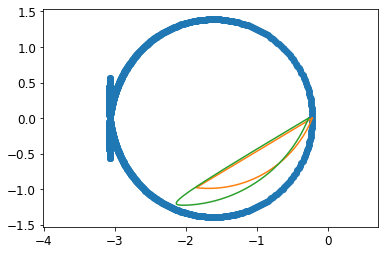

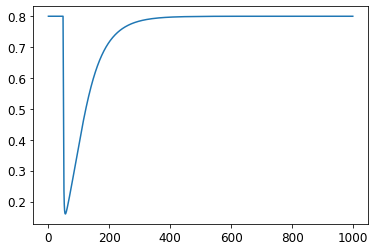

In [8]:
foo.plot_photon_response(sweep.s21)
plt.figure()
plt.plot(foophase);

In [9]:
x = lowpass_to_use(lit_res_measurment.iq_response.real)+lowpass_to_use(lit_res_measurment.iq_response.imag)*1j
lit_res_measurment.decimated_iq=x[::2]
lit_res_measurment.decimated_tvec = lit_res_measurment.photons.tvec[lowpass_drop:][::2]
phase = np.angle(lit_res_measurment.decimated_iq+np.pi/2)/np.pi+.8

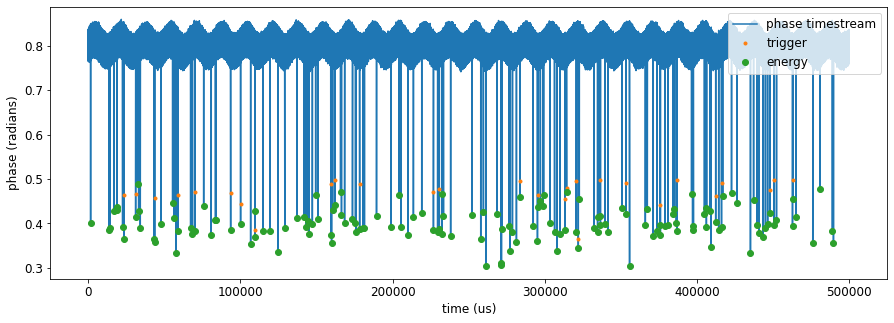

2277


In [10]:
trigger_threshold=.5
max_noise_windows = 2000
noise_npoints = 750 # psd is calcualted from overlapping segments of this length (defualt is 50% ovlp).
n_ovl = 2 # factor by which noise_npoints is multiplied by to determine the minimum noise window

post_pulse_window = 745
pre_pulse_avoidance = 5
post_pulse_avoidance = post_pulse_window+10

n_template=post_pulse_window+pre_pulse_avoidance

readout = MKIDReadout()
readout.trigger(phase, fs=quasiparticle_timestream.fs/2, threshold=trigger_threshold, deadtime=2*30)

pulse_window_starts = readout.photon_energy_idx-pre_pulse_avoidance
pulse_window_stops = readout.photon_energy_idx+post_pulse_window
usable_pulse_windows = np.zeros_like(pulse_window_starts,dtype=bool)
usable_pulse_windows = np.concatenate(((pulse_window_starts[1:]-pulse_window_stops[:-1])>0, 
                                       [pulse_window_stops[-1]<=phase.size]))
usable_pulse_windows[0]=pulse_window_starts[0]>=0
# usable_pulse_windows[:-1] = (pulse_window_stops-pulse_window_starts)[:-1] < np.diff(readout.photon_energy_idx)
# usable_pulse_windows[0]=pulse_window_starts[0]>=0
# usable_pulse_windows[-1]=pulse_window_stops[-1]<=phase.size
pulse_slices = [slice(*x) for x in zip(pulse_window_starts[usable_pulse_windows],
                                       pulse_window_stops[usable_pulse_windows])]
usable_idx = readout.photon_energy_idx[usable_pulse_windows]

window = np.arange(-pre_pulse_avoidance, n_template - pre_pulse_avoidance)
readout.usable_photon_energy_idx = usable_idx
readout.plot_triggers(phase, energies=True, xlim=(0, 500000)); plt.show()
pulse_window_indices = (readout.usable_photon_energy_idx + window[:, np.newaxis]).T
raw_pulses = phase[pulse_window_indices] # n_pulsesfound x n_template array where each row is one pulse
print(usable_pulse_windows.sum())

## Now have IQs, lowpassed & decimated IQS, and phases

1. plot noise psd
2. plot psd of averaged pulses
3. plot average psd of pulses
4. plot lowpass psd of averaged pulses


In [11]:
try:
    del psd
except:
    pass
noise_window_starts = np.concatenate(([0], readout.photon_energy_idx+post_pulse_avoidance))
noise_window_stops = np.concatenate((readout.photon_energy_idx-pre_pulse_avoidance,[phase.size]))
usable_noise_windows = (noise_window_stops-noise_window_starts) > noise_npoints*n_ovl  # wide enough
usable_noise_windows[:-1] &= np.diff(noise_window_starts)>post_pulse_avoidance  # doesn't overlap with a pulse
#usable_noise_windows &= noise_window_stops<readout.photon_energy_idx[1:]
noise_slices = [slice(*x) for x in zip(noise_window_starts[usable_noise_windows],
                                       noise_window_stops[usable_noise_windows])]

if len(noise_slices) < max_noise_windows:
    print(f'Only found {len(noise_slices)} good noise windows, less that the max of {max_noise_windows}. '
          f'Consider reducing noise window size with noise_points or n_ovlp.')
windows_used = 0
for sl in noise_slices[:max_noise_windows]:
    noise_data = phase[sl]
    x= sp.signal.welch(noise_data - noise_data.mean(), fs=quasiparticle_timestream.fs/2, 
                       nperseg=noise_npoints, detrend="constant", return_onesided=True, scaling="density")[1]
    try:
        psd+=x
    except NameError:
        psd=x
        
windows_used = np.sum((noise_window_stops-noise_window_starts)[usable_noise_windows]/noise_npoints)

if not len(noise_slices):
    print(f'There was no noise data. Assuming white noise.')
    psd[:] = np.ones(int(noise_npoints / 2. + 1))
else:
    psd /= min(len(noise_slices), max_noise_windows)

Only found 1317 good noise windows, less that the max of 2000. Consider reducing noise window size with noise_points or n_ovlp.


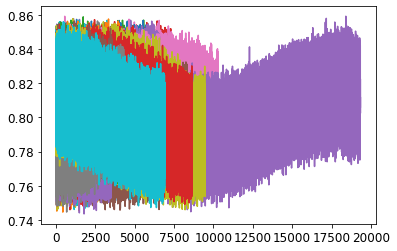

In [12]:
for sl in np.random.choice(noise_slices, size=50, replace=False):
    noise_data = phase[sl]
    plt.plot(noise_data, label=f'{sl.start}-{sl.stop}')
#plt.legend()

In [13]:
import scipy as sp
# cut out noise triggers
min_idxs = raw_pulses.argmin(axis=1)
mode, count = sp.stats.mode(min_idxs)
mode, count = mode[0], count[0]
if count / raw_pulses.shape[0] < 0.8:
    print(f'Warning: {(count / raw_pulses.shape[0])*100:.1f} % of pulse minima differ from the mode. These may be noise triggers. Check deadtime and holdoff settings. Proceeding without noise cuts.')
    pulses_final = raw_pulses
else:
    print(f'Eliminating {(1-(int(count) / raw_pulses.shape[0])) * 100:.1f}% of pulses which appear to be noise.')
    # pulses_noisecut = raw_pulses[min_idxs == mode]
    multis = ((raw_pulses[:,:pre_pulse_avoidance-2]<.5).sum(1).astype(bool) |
              (raw_pulses[:,pre_pulse_avoidance+2:]<.5).sum(1).astype(bool))
    # nonsingle = (raw_pulses[:,pre_pulse_avoidance+2:]<.5).sum(1)>1
    print(f'Eliminating {multis.sum()} pulses which appear to be doubles or greater.')
    pulses_final = raw_pulses[~multis]

Eliminating 0.0% of pulses which appear to be noise.
Eliminating 31 pulses which appear to be doubles or greater.


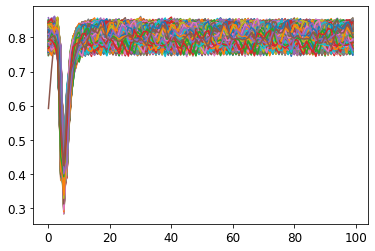

In [14]:
plt.plot(pulses_final[:,:100].T);

In [15]:
def shift_and_normalize(template, ntemplate, offset):
    template = template.copy()
    if template.min() != 0:  # all weights could be zero
        template /= np.abs(template.min())  # correct over all template height

    # shift template (max may not be exactly at offset due to filtering and imperfect default template)
    start = 10 + np.argmin(template) - offset
    stop = start + ntemplate
    template = np.pad(template, 10, mode='wrap')[start:stop]  # use wrap to not change the frequency content
    return template

raw_template = pulses_final.sum(axis=0)
shifted_template = raw_template-raw_template[0:pre_pulse_avoidance//2].mean() # make pulse start at 0
normalized_template = shift_and_normalize(shifted_template, n_template, pre_pulse_avoidance)

In [16]:
cutoff = 0.1 # lowpass cutoff used during filter generation to compensate for effects of lowpass filters in digital readout?
dt = 1/(quasiparticle_timestream.fs/2)
window_filter = True
n_filter= 42

In [17]:
optimal_filter = wiener(normalized_template, psd, noise_npoints, nfilter=n_filter, 
                        cutoff=0*cutoff, normalize=True)
if window_filter:
    window = sp.signal.windows.hamming(optimal_filter.size, sym=False)
    optimal_filter_w = window * optimal_filter

In [18]:
#TODO generate way more pulses and see if knee disappears

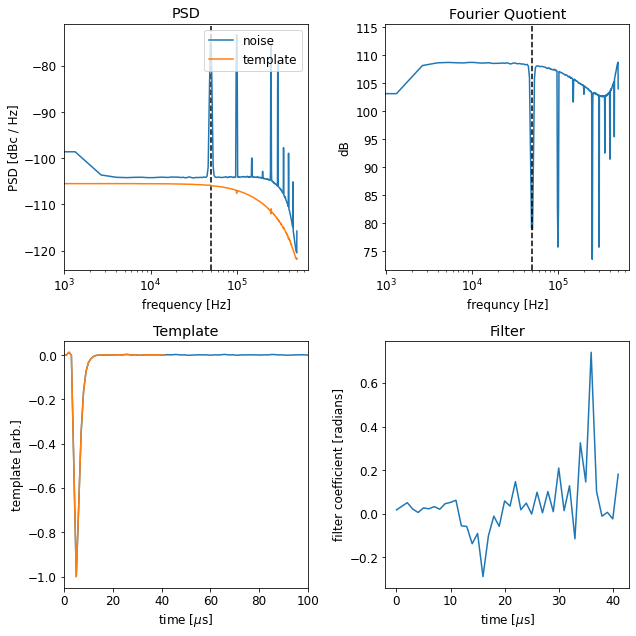

In [19]:
from mkidreadoutanalysis.jenny_ofilt_helpers import  ofilt_summary_plot
def ofilt_summary_plot(psd, dt, noise_nwindow, filter, template, cutoff):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
    # PSD
    ax[0, 0].set_xlabel("frequency [Hz]")
    ax[0, 0].set_ylabel("PSD [dBc / Hz]")
    ax[0, 0].axvline(cutoff*1/dt/2, color='black', linestyle='--')
    f_noise = np.fft.rfftfreq(noise_nwindow, d=dt)
    ax[0, 0].semilogx(f_noise, 10 * np.log10(psd), label='noise')
    f_template = np.fft.rfftfreq(template.size, d=dt)
    template_fft =np.abs(np.fft.rfft(template))
    ax[0, 0].semilogx(f_template, 10 * np.log10(template_fft*dt*1e-5), label='template')
    ax[0, 0].legend(loc='upper right')
    ax[0, 0].set_title('PSD')
    # FOURIER QUOTIENT
    ax[0, 1].semilogx(f_noise, 10 * np.log10(np.abs(np.conj(np.fft.rfft(template)) / psd)))
    ax[0, 1].set_xlabel("frequncy [Hz]")
    ax[0, 1].set_ylabel("dB")
    ax[0, 1].axvline(cutoff*1/dt/2, color='black', linestyle='--')
    ax[0, 1].set_title('Fourier Quotient')
    # TEMPLATE
    ax[1, 0].set_xlabel(r"time [$\mu$s]")
    ax[1, 0].set_ylabel("template [arb.]")
    ax[1, 0].plot(np.arange(template.size) * dt * 1e6, template)
    ax[1, 0].plot(np.arange(filter.size) * dt * 1e6, template[:filter.size])
    ax[1, 0].set_title('Template')
    ax[1,0].set_xlim(0,100)
    # FILTER
    ax[1, 1].set_xlabel(r"time [$\mu$s]")
    ax[1, 1].set_ylabel("filter coefficient [radians]")
    ax[1, 1].plot(np.arange(filter.size) * dt * 1e6, filter)
    ax[1, 1].set_title('Filter')
    plt.tight_layout()
    plt.show()
ofilt_summary_plot(psd, dt, noise_npoints, optimal_filter, normalized_template, cutoff)